## Covid-19 Tweet's Sentiment Analysis
##### (Multiclass sentiment analysis of textual data using Neural Networks)

**Author:** *Harsh Priye*

### About the Dataset:
* Dataset used in this project consists of a **collection of tweets** that were **posted during covid-19 pandemic** by users from different locations across the globe.
* Datset **consists of tweets and sentiments** reflected from them, alongwith other information like location, date, username etc.

### Major Headings:
* **Data Preparation and Basic Preprocessing**
  * Feature Reduction
  * Null Cleaning
  * Train-Test-Split
* **Natural Language Processing (NLP)**
  * Lowercasing sentences
  * Truncating:
    * Hashtags, Mentions, URLs, Emojis
    * Punctuation, Numbers, Special Characters, Escape Characters etc.
    * Stopwords
  * Text normalization:
      * *Stemming*
      * ***Lemmatization:*** Word Net Lemmatizer
  * Stopword Removal

* **Word Embedding and Sequence Padding**

* **3 Class Sentiment Classification Model**
  * **Label Encoding** and **Class Reduction**
  * **Building Neural Network:** Using Bi-Directional LSTM Layers
* **Summary**

In [1]:
# Basic Libraries/Dependencies:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import os
os.chdir('/kaggle/input')
os.listdir()

['covid-19-nlp-text-classification']

In [2]:
# tensorflow dependencies:
import tensorflow as tf
from tensorflow import keras
print(f"Tensorflow Version: {tf.__version__}")

Tensorflow Version: 2.12.0


## Data Preparation

In [3]:
df=pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding='latin1')
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [4]:
# function to keep only Text and label:
def create_data(df):
    x=df['OriginalTweet']
    y=df['Sentiment']
    df=pd.concat((x,y),axis=1, keys=['texts','labels'])
    return df

In [5]:
%%time
#reduced data:
df=create_data(df)
df

CPU times: user 1.84 ms, sys: 979 µs, total: 2.82 ms
Wall time: 2.85 ms


,texts,labels
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...
41152,Airline pilots offering to stock supermarket s...,Neutral
41153,Response to complaint not provided citing COVI...,Extremely Negative
41154,You know itÂs getting tough when @KameronWild...,Positive
41155,Is it wrong that the smell of hand sanitizer i...,Neutral


#### Nulls and Cardinality

In [6]:
overview=pd.concat([df.isnull().sum(),df.nunique()],axis=1,keys=['Null Counts','Cardinality'])
overview

,Null Counts,Cardinality
texts,0,41157
labels,0,5


In [7]:
# # function for removing NULL values:
# def remove_nulls(df):
#     idx=df.loc[df.iloc[:,0].isnull()].index
#     idx2=df.loc[df.iloc[:,1].isnull()].index
#     df_clean=df.drop(idx)
#     df_clean=df.drop(idx2)
#     return df_clean

#### Train-Test Split

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['texts'], df['labels'], test_size=0.2, random_state=42)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((32925,), (32925,), (8232,), (8232,))

In [9]:
# text before cleaning:
x_train.iloc[0]

'Unemployment claims made online in Virginia this week:\r\r\n\r\r\nMonday: 426\r\r\nTuesday: 2,150\r\r\n\r\r\nAnd the numbers are going to get bigger. https://t.co/fUeg2RL2dl'

## Natural Language Processing (NLP)
* lowercasing sentences
* Truncating:
  * Hashtags, Mentions, URLs, Emojis
  * Punctuation, Numbers, Special Characters, Escape Characters etc.
  * Stopwords
* Text normalization:
    * *Stemming*
    * ***Lemmatization:*** Word Net Lemmatizer
* Stopword Removal

In [10]:
# dependencies:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# initiating lemmatizer(kaggle specific):
# Define a install path for nltk
if os.environ.get('KAGGLE_KERNEL_RUN_TYPE', ''):
    nltk_path='/kaggle/working'
else:
    nltk_path="{}".format(os.getcwd())

isnltk_installed = os.path.isdir(f'{nltk_path}/nltk_data/corpora/wordnet')

# Install relevent libraries to nltk path
if isnltk_installed:
    nltk.data.path.append(f'{nltk_path}/nltk_data')
else:
    # Make directort name 'nlrk_data' in current work directory '/kaggle/working/'
    !mkdir nltk_data
    # Download neccessaty package as .zip file ('corpora' directory are automatically created)
    nltk.download('wordnet', f"{nltk_path}/nltk_data")
    nltk.download('omw-1.4', f"{nltk_path}/nltk_data/")
    # Unzip .zip file in folder '/kaggle/working/nltk_data/corpora'
    !unzip /kaggle/working/nltk_data/corpora/wordnet.zip -d /kaggle/working/nltk_data/corpora
    !unzip /kaggle/working/nltk_data/corpora/omw-1.4.zip -d /kaggle/working/nltk_data/corpora
    # Add custom location nltk file data path
    nltk.data.path.append(f'{nltk_path}/nltk_data')


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
mkdir: cannot create directory ‘nltk_data’: Read-only file system
[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /kaggle/working/nltk_data/...
Archive:  /kaggle/working/nltk_data/corpora/wordnet.zip
   creating: /kaggle/working/nltk_data/corpora/wordnet/
  inflating: /kaggle/working/nltk_data/corpora/wordnet/lexnames  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/data.verb  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.adv  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.verb  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/cntlist.rev  

In [11]:
# function for NLP:
def nlp(text):
  def remove_emoji(text):
    emoji_pattern = re.compile(
      '['
      u'\U0001F600-\U0001F64F'  # emoticons
      u'\U0001F300-\U0001F5FF'  # symbols & pictographs
      u'\U0001F680-\U0001F6FF'  # transport & map symbols
      u'\U0001F1E0-\U0001F1FF'  # flags
      u'\U00002702-\U000027B0'
      u'\U000024C2-\U0001F251'
      ']+',
      flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
  def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    tokenizer = TweetTokenizer()
    words = tokenizer.tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    return words
  text = remove_emoji(text)
  text = str(text).lower()
  text = re.sub(r'https?://\S+|www\.\S+', '', text)
  text = re.sub(r'RT[\s]+', '', text)
  text = re.sub(r'@\S+', '', text)
  text = re.sub(r'#', '', text)
  text = re.sub(r'\[', '', text)
  text = re.sub(r'\]', '', text)
  text = re.sub('â\\x92', "'", text)
  text = re.sub('â\S+', '', text)
  text = re.sub('\.+', '.', text)
  text = re.sub('&amp;', 'and', text)
  text = re.sub("let's", 'let us', text)
  text = re.sub("'s", ' is', text)
  text = re.sub("'re", ' are', text)
  text = re.sub("ain't", 'am not', text)
  text = re.sub("won't", 'will not', text)
  text = re.sub("n't", ' not', text)
  text = re.sub("'ve", ' have', text)
  text = re.sub("y'all", "you all", text)
  text = re.sub("'ll", ' will', text)
  text = re.sub("i'd", 'i would', text)
  text = re.sub("i'm", 'i am', text)
  text = re.sub(r"[^a-z<>!?\s]+", '', text)
  text = re.sub('covid\S*', 'coronavirus', text)
  text = re.sub('corona\S*', 'coronavirus', text)
  text = re.sub(r'\s+', ' ', text)
  text = lemmatize(text)
  return text

In [12]:
%%time
import tqdm.notebook as tq
x_train_clean = np.array([nlp(text) for text in tq.tqdm(x_train.values, desc='Progress')], dtype='O')
x_test_clean = np.array([nlp(sent) for sent in tq.tqdm(x_test.values, desc='Progress')], dtype='O')

Progress:   0%|          | 0/32925 [00:00<?, ?it/s]

Progress:   0%|          | 0/8232 [00:00<?, ?it/s]

CPU times: user 2min 26s, sys: 20 s, total: 2min 46s
Wall time: 2min 46s


In [13]:
# text after cleaning:
print(x_train_clean[0])

['unemployment', 'claim', 'made', 'online', 'virginia', 'week', 'monday', 'tuesday', 'number', 'going', 'get', 'bigger']


In [14]:
# array of list (of clean text data)
x_train_clean

array([list(['unemployment', 'claim', 'made', 'online', 'virginia', 'week', 'monday', 'tuesday', 'number', 'going', 'get', 'bigger']),
       list(['panicbuying', 'response', 'coronavirus', 'could', 'damaging', 'effect', 'agri', 'supply', 'chain', 'say', 'agri', 'economist', 'lunathi', 'hlakanyane', 'farmerschange', 'coronavirus', 'coronavirus']),
       list(['ecigarette', 'user', 'tobacco', 'smoker', 'danger', 'new', 'coronavirus', 'average', 'healthy', 'person']),
       ...,
       list(['commented', 'poll', 'online', 'shopping', 'normal', 'coronavirus', 'crisis', '?']),
       list(['wife', 'got', 'laid', 'yesterday', 'small', 'retail', 'store', 'work', 'got', 'walloped', 'walkin', 'business', 'vanishing', 'coronavirus', 'long', 'thinking', 'taking', 'ei', 'process', 'claim', 'right', '?']),
       list(['humanity', 'doomed', 'coronavirus', 'coronavirus', 'toiletpaper', 'toiletpapier', 'coronavirus', 'coronavirus'])],
      dtype=object)

## Word Embedding and Sequence Padding

In [15]:
max_len = max([len(sent) for sent in x_train_clean])
max_len

151

#### Word Embedding

In [16]:
from keras.preprocessing.text import Tokenizer

tok = Tokenizer(filters=None, oov_token='<OOV>')
tok.fit_on_texts(list(x_train_clean)+list(x_test_clean))

x_train_seq = tok.texts_to_sequences(x_train_clean)
x_test_seq = tok.texts_to_sequences(x_test_clean)

In [17]:
# checking random data:
print(x_train_seq[0])
print(x_train_clean[0])

[815, 719, 220, 13, 3442, 39, 667, 1239, 273, 31, 18, 2630]
['unemployment', 'claim', 'made', 'online', 'virginia', 'week', 'monday', 'tuesday', 'number', 'going', 'get', 'bigger']


In [18]:
# unique word tokens:
word_index = tok.word_index
len(word_index)

42931

#### Sequence Padding

In [19]:
from keras.utils import pad_sequences
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len, padding='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len, padding='post')

In [20]:
x_train_pad.shape, x_test_pad.shape

((32925, 151), (8232, 151))

## Label Encoding


In [21]:
# before grouping:
print(np.unique(y_train))
print(np.unique(y_test))

['Extremely Negative' 'Extremely Positive' 'Negative' 'Neutral' 'Positive']
['Extremely Negative' 'Extremely Positive' 'Negative' 'Neutral' 'Positive']


In [22]:
def encoder(data, enc=None):
  data[data=='Extremely Negative'] = 'Negative'
  data[data=='Extremely Positive'] = 'Positive'
  if(enc==None):
    from sklearn.preprocessing import OneHotEncoder
    onehot = OneHotEncoder()
    data_enc = onehot.fit_transform(np.array(data).reshape(-1,1)).toarray()
    return data_enc,onehot
  else:
    data_enc = enc.transform(np.array(data).reshape(-1,1)).toarray()
    return data_enc

In [23]:
y_train_enc, enc = encoder(y_train)
y_test_enc = encoder(y_test,enc)

In [24]:
y_train_enc, y_train_enc.shape

(array([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.]]),
 (32925, 3))

In [25]:
y_test_enc, y_test_enc.shape

(array([[0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        ...,
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.]]),
 (8232, 3))

## Building Neural Networks

In [26]:
model = keras.Sequential([
    keras.layers.Embedding(len(word_index)+1, 151, input_length=max_len),
    keras.layers.SpatialDropout1D(0.5),
    keras.layers.Bidirectional(keras.layers.LSTM(100, recurrent_dropout=0.3)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.6),

    keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 151, 151)          6482732   
                                                                 
 spatial_dropout1d (SpatialD  (None, 151, 151)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 200)              201600    
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                        

#### Training

In [27]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.1)

logs = model.fit(x_train_pad,y_train_enc, validation_data=(x_test_pad, y_test_enc),
                    epochs=80, batch_size=512, callbacks=[es, reduce_lr])

Epoch 1/80
65/65 [==============================] - 93s 1s/step - loss: 1.5242 - accuracy: 0.4226 - val_loss: 1.0367 - val_accuracy: 0.4394 - lr: 0.0010
Epoch 2/80
65/65 [==============================] - 81s 1s/step - loss: 0.8946 - accuracy: 0.6285 - val_loss: 0.9906 - val_accuracy: 0.5514 - lr: 0.0010
Epoch 3/80
65/65 [==============================] - 78s 1s/step - loss: 0.5761 - accuracy: 0.7680 - val_loss: 0.9114 - val_accuracy: 0.5378 - lr: 0.0010
Epoch 4/80
65/65 [==============================] - 78s 1s/step - loss: 0.4138 - accuracy: 0.8483 - val_loss: 0.7978 - val_accuracy: 0.6542 - lr: 0.0010
Epoch 5/80
65/65 [==============================] - 76s 1s/step - loss: 0.3134 - accuracy: 0.8894 - val_loss: 0.6865 - val_accuracy: 0.7032 - lr: 0.0010
Epoch 6/80
65/65 [==============================] - 75s 1s/step - loss: 0.2546 - accuracy: 0.9129 - val_loss: 0.6238 - val_accuracy: 0.7406 - lr: 0.0010
Epoch 7/80
65/65 [==============================] - 74s 1s/step - loss: 0.2135 - a

#### Plotting Training Log

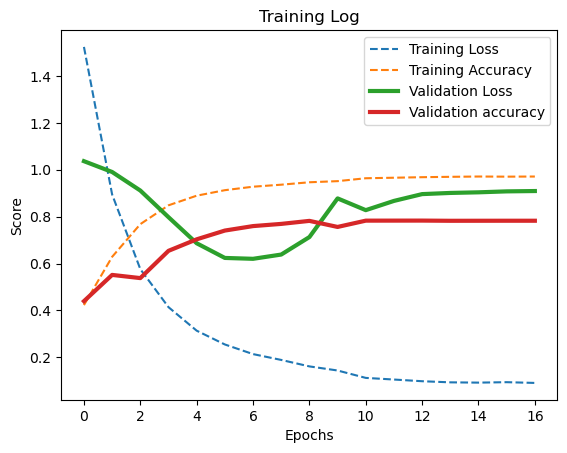

In [28]:
import matplotlib.pyplot as plt
plt.title('Training Log')
plt.plot(logs.history['loss'], label='Training Loss', linestyle='dashed')
plt.plot(logs.history['accuracy'], label='Training Accuracy', linestyle='dashed')
plt.plot(logs.history['val_loss'], label='Validation Loss', linewidth=3)
plt.plot(logs.history['val_accuracy'], label='Validation accuracy', linewidth=3)
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.show()

In [29]:
model.evaluate(x_test_pad,y_test_enc)

258/258 [==============================] - 20s 77ms/step - loss: 0.6201 - accuracy: 0.7597


[0.6200910806655884, 0.7597181797027588]

In [30]:
y_pred = model.predict(x_test_pad)

258/258 [==============================] - 20s 76ms/step


In [31]:
y_pred = enc.inverse_transform(y_pred)
y_pred = np.squeeze(y_pred)
y_pred

array(['Negative', 'Negative', 'Neutral', ..., 'Positive', 'Neutral',
       'Negative'], dtype=object)

In [32]:
res = pd.concat((y_test.reset_index(drop=True),pd.Series(y_pred)), axis=1, keys=['actual','predicted'])
res

,actual,predicted
0,Neutral,Negative
1,Negative,Negative
2,Positive,Neutral
3,Positive,Positive
4,Negative,Positive
...,...,...
8227,Positive,Positive
8228,Positive,Positive
8229,Negative,Positive
8230,Neutral,Neutral


In [33]:
# instances of correct predictions:
x = len(res.loc[res['actual']==res['predicted']])
print(f"Correct Predictions: {x} out of {len(res)} instances")

Correct Predictions: 6254 out of 8232 instances


In [34]:
print(f"Final Validation accuracy: {x/len(res)*100}")

Final Validation accuracy: 75.97181729834791


## Testing

In [35]:
test_data = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv', encoding='latin1')
test_data

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative


In [36]:
test_data = create_data(test_data)
test_data

,texts,labels
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,When I couldn't find hand sanitizer at Fred Me...,Positive
2,Find out how you can protect yourself and love...,Extremely Positive
3,#Panic buying hits #NewYork City as anxious sh...,Negative
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
...,...,...
3793,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,Did you panic buy a lot of non-perishable item...,Negative
3795,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,Gov need to do somethings instead of biar je r...,Extremely Negative


In [37]:
test_overview=pd.concat([test_data.isnull().sum(),test_data.nunique()],axis=1,keys=['Null Counts','Cardinality'])
test_overview

,Null Counts,Cardinality
texts,0,3798
labels,0,5


In [38]:
import tqdm.notebook as tq
test_data_clean = np.array([nlp(text) for text in tq.tqdm(test_data['texts'].values, desc='Progress')], dtype='O')

Progress:   0%|          | 0/3798 [00:00<?, ?it/s]

In [39]:
test_data_clean

array([list(['trending', 'new', 'yorkers', 'encounter', 'empty', 'supermarket', 'shelf', 'pictured', 'wegmans', 'brooklyn', 'soldout', 'online', 'grocer', 'foodkick', 'maxdelivery', 'coronavirus', 'shopper', 'stock']),
       list(['could', 'find', 'hand', 'sanitizer', 'fred', 'meyer', 'turned', 'amazon', 'pack', 'purell', '?', '?', '!', '!', 'check', 'coronavirus', 'concern', 'driving', 'price']),
       list(['find', 'protect', 'loved', 'one', 'coronavirus', '?']), ...,
       list(['asst', 'prof', 'economics', 'talking', 'recent', 'research', 'coronavirus', 'impact', 'economy', 'watch', 'starting']),
       list(['gov', 'need', 'somethings', 'instead', 'biar', 'je', 'rakyat', 'assume', 'lockdown', 'ke', 'even', 'worst', 'harini', 'semua', 'supermarket', 'crowded', 'like', 'hell', 'lagi', 'mudah', 'virus', 'tu', 'tersebar', '?', '?', 'coronavirus']),
       list(['member', 'committed', 'safety', 'employee', 'endusers', 'monitoring', 'coronavirus', 'rest', 'assured', 'tissue', 'manufa

In [40]:
l = max([len(sent) for sent in test_data_clean])
l

40

In [41]:
test_data_seq = tok.texts_to_sequences(test_data_clean)

In [42]:
print(test_data_seq[0])
print(test_data_clean[0])

[1910, 37, 4786, 5719, 144, 6, 51, 7143, 4495, 3107, 7016, 13, 1405, 1, 1, 2, 203, 28]
['trending', 'new', 'yorkers', 'encounter', 'empty', 'supermarket', 'shelf', 'pictured', 'wegmans', 'brooklyn', 'soldout', 'online', 'grocer', 'foodkick', 'maxdelivery', 'coronavirus', 'shopper', 'stock']


In [43]:
test_data_pad = pad_sequences(test_data_seq, maxlen=l, padding='post')

In [44]:
test_label_enc = encoder(test_data['labels'],enc)
test_label_enc

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [45]:
model.evaluate(test_data_pad,test_label_enc)

119/119 [==============================] - 3s 22ms/step - loss: 0.6374 - accuracy: 0.7478


[0.6374061107635498, 0.7477619647979736]

## Testing on Randomly Generated Data

In [46]:
str1 = "I am going to die in this pandemic."
str2 = "I am glad that we are still safe. #survived #grateful"
str3 = "Pass me a pizza."
str4 = "@sakshi, I hate you."
str5 = "I will submit my assignment tomorrow. @prof_NSUT @dean_ACAD"
data=[]
data.append(str1)
data.append(str2)
data.append(str3)
data.append(str4)
data.append(str5)

data=pd.Series(data)
data

0                  I am going to die in this pandemic.
1    I am glad that we are still safe. #survived #g...
2                                     Pass me a pizza.
3                                 @sakshi, I hate you.
4    I will submit my assignment tomorrow. @prof_NS...
dtype: object

In [47]:
data_clean = np.array([nlp(text) for text in data.values], dtype='O')
data_clean

array([list(['going', 'die', 'pandemic']),
       list(['glad', 'still', 'safe', 'survived', 'grateful']),
       list(['pas', 'pizza']), list(['hate']),
       list(['submit', 'assignment', 'tomorrow'])], dtype=object)

In [48]:
mx_len = max([len(sent) for sent in data_clean])
data_seq = tok.texts_to_sequences(data_clean)
data_pad = pad_sequences(data_seq, maxlen=mx_len, padding='post')

In [49]:
pred = model.predict(data_pad)
pred = enc.inverse_transform(pred)

1/1 [==============================] - 0s 431ms/step


In [50]:
res = pd.concat((data,pd.Series(pred.ravel())), axis=1, keys=['texts', 'sentiments'])
res

,texts,sentiments
0,I am going to die in this pandemic.,Negative
1,I am glad that we are still safe. #survived #g...,Positive
2,Pass me a pizza.,Positive
3,"@sakshi, I hate you.",Negative
4,I will submit my assignment tomorrow. @prof_NS...,Neutral


satisfactory results (^.^)

## Model Description and Summary

* Model description:
  * Model Structure:
    * An **Embedding Layer**: Converts each word into a fixed-length vector of defined size.
    * A **bidirectional LSTM layer** of 100 units.
    * A **Dense layer** of 1024 units, with **ReLu Activation**.
    * **Dense Output Layer** of 3 units with **Softmax Activation**. (Suitable multiclass classification)
    
  * Loss metric used : **Categorical Crossentropy** (Suitable for multiclass classification)
  * Optimizer used : **Adam**
  * Initial Leraning Rate : **0.001**
  * Callbacks used:
    * **Early Stopping** : Stops the training process when loss becomes constant.
    * **ReduceLRonPlateau** : Gradually decreases learning rate when training process reach plateau.

* Summary
  * Training Data Score :  0.97
  * Validation Data Score :  0.78
  * Test Data Score :  0.77

**Conclusion:** Our model has performed really well while training, it hasn't performed very well on validation and test data.

This is because our model overfitted on the training data.